In [2]:
import numpy as np
import pandas as pd
import sklearn.linear_model as lm
from sklearn import *
import matplotlib.pyplot as plt
import seaborn as sns
from random import *
import re
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams.update({'font.size': 15})

import warnings
warnings.filterwarnings('ignore')

! unzip Spotify.zip

Archive:  Spotify.zip
   creating: Spotify/
  inflating: __MACOSX/._Spotify      
  inflating: Spotify/tracks.csv      
  inflating: __MACOSX/Spotify/._tracks.csv  
  inflating: Spotify/data_by_year_o.csv  
  inflating: __MACOSX/Spotify/._data_by_year_o.csv  
  inflating: Spotify/data_by_genres_o.csv  
  inflating: __MACOSX/Spotify/._data_by_genres_o.csv  
  inflating: Spotify/artists.csv     
  inflating: __MACOSX/Spotify/._artists.csv  
  inflating: Spotify/dict_artists.json  
  inflating: __MACOSX/Spotify/._dict_artists.json  
  inflating: Spotify/data_o.csv      
  inflating: __MACOSX/Spotify/._data_o.csv  
  inflating: Spotify/data_by_artist_o.csv  
  inflating: __MACOSX/Spotify/._data_by_artist_o.csv  


# Spotify Dataset 1922-2021

This dataset was created by [Yamac Eren Ay](https://www.kaggle.com/yamaerenay). This dataset contains data on about 600K tracks released between 1922 and 2021. I downloaded this data from Kaggle \[[link](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks)\]. 

This dataset contains the following files:

* data_o.csv (audio features of tracks, original data, 170k rows)
* data_by_artist_o.csv (audio features of artists, derived from data_o.csv, 30k rows)
* data_by_year_o.csv (audio features of years, derived from data_o.csv, 100 rows)
* data_by_genres_o.csv (audio features of genres, derived from databyartist_o.csv, 3k rows)
* tracks.csv (audio features of tracks, 600k rows)
* artists.csv (popularity metrics of artists, 1.1M rows)
* dict_artists.json (artists related artists, represented by ids)

<!-- We will be working only with tracks. Each row entry has data for a unique track (the granularity of the data). The features are extracted using audio processing. The audio features of artists are grouped by genres. in the aggregation process, i calculated means for numerical variables and modes for categorical ones.
popularity
instrumentalness, etc. -->


## Dataset Description

In our analysis, we will be working only with the `tracks.csv` file. Its granularity is each track - each row in contains data on one unique track. The following are the features in this file and their descriptions:

**Primary:**
- id (Id of track generated by Spotify)

**Numerical:**
- acousticness (Ranges from 0 to 1)
- danceability (Ranges from 0 to 1)
- energy (Ranges from 0 to 1)
- duration_ms (Integer typically ranging from 200k to 300k)
- instrumentalness (Ranges from 0 to 1)
- valence (Ranges from 0 to 1)
- popularity (Ranges from 0 to 100)
- tempo (Float typically ranging from 50 to 150)
- liveness (Ranges from 0 to 1)
- loudness (Float typically ranging from -60 to 0)
- speechiness (Ranges from 0 to 1)

**Dummy:**
- mode (0 = Minor, 1 = Major)
- explicit (0 = No explicit content, 1 = Explicit content)

**Categorical:**
- key (All keys on octave encoded as values ranging from 0 to 11, starting on C as 0, C# as 1 and so on…)
- timesignature (The predicted timesignature, most typically 4)
- artists (List of artists mentioned)
- artists (Ids of mentioned artists)
- release_date (Date of release mostly in yyyy-mm-dd format, however precision of date may vary)
- name (Name of the song)

In [3]:
tracks = pd.read_csv('Spotify/tracks.csv')
tracks

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.744000,0.1510,0.1270,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.000000,0.1480,0.6550,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.021800,0.2120,0.4570,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.918000,0.1040,0.3970,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.130000,0.3110,0.1960,103.220,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586667,5rgu12WBIHQtvej2MdHSH0,云与海,50,258267,0,['阿YueYue'],['1QLBXKM5GCpyQQSVMNZqrZ'],2020-09-26,0.560,0.5180,0,-7.471,0,0.0292,0.785,0.000000,0.0648,0.2110,131.896,4
586668,0NuWgxEp51CutD2pJoF4OM,blind,72,153293,0,['ROLE MODEL'],['1dy5WNgIKQU6ezkpZs4y8z'],2020-10-21,0.765,0.6630,0,-5.223,1,0.0652,0.141,0.000297,0.0924,0.6860,150.091,4
586669,27Y1N4Q4U3EfDU5Ubw8ws2,What They'll Say About Us,70,187601,0,['FINNEAS'],['37M5pPGs6V1fchFJSgCguX'],2020-09-02,0.535,0.3140,7,-12.823,0,0.0408,0.895,0.000150,0.0874,0.0663,145.095,4
586670,45XJsGpFTyzbzeWK8VzR8S,A Day At A Time,58,142003,0,"['Gentle Bones', 'Clara Benin']","['4jGPdu95icCKVF31CcFKbS', '5ebPSE9YI5aLeZ1Z2g...",2021-03-05,0.696,0.6150,10,-6.212,1,0.0345,0.206,0.000003,0.3050,0.4380,90.029,4


# Research Question

In this analysis, we want to investigate if we can use the features in this dataset to predict the _popularity_ of a new track (as assigned according to Spotify data) accurately. **Specifically, we want to determine if a track is popular or not, where we define a track to be popular if its popularity is strictly greater than 40 (the population mean)**. And, if can predict this accurcately, what final features should be used to predict the popularity of a new track.

The popularity of a track is a real feature engineered by Spotify, and can be found in Spotify data's [track](https://developer.spotify.com/documentation/web-api/reference/tracks/get-track/) section. Primarily, it depends on how many times a track has been played, and how recent those plays are.

Since we are predicting whether or not a track is popular (a boolean outcome variable), we can use a **Logistic Regression Classifier**.

In [9]:
tracks.loc[:, 'is_popular'] = (tracks.loc[:, 'popularity'] > 40).astype(int)
tracks

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,is_popular
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,...,-13.338,1,0.4510,0.674,0.744000,0.1510,0.1270,104.851,3,0
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,...,-22.136,1,0.9570,0.797,0.000000,0.1480,0.6550,102.009,1,0
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,...,-21.180,1,0.0512,0.994,0.021800,0.2120,0.4570,130.418,5,0
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,...,-27.961,1,0.0504,0.995,0.918000,0.1040,0.3970,169.980,3,0
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,...,-16.900,0,0.0390,0.989,0.130000,0.3110,0.1960,103.220,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586667,5rgu12WBIHQtvej2MdHSH0,云与海,50,258267,0,['阿YueYue'],['1QLBXKM5GCpyQQSVMNZqrZ'],2020-09-26,0.560,0.5180,...,-7.471,0,0.0292,0.785,0.000000,0.0648,0.2110,131.896,4,1
586668,0NuWgxEp51CutD2pJoF4OM,blind,72,153293,0,['ROLE MODEL'],['1dy5WNgIKQU6ezkpZs4y8z'],2020-10-21,0.765,0.6630,...,-5.223,1,0.0652,0.141,0.000297,0.0924,0.6860,150.091,4,1
586669,27Y1N4Q4U3EfDU5Ubw8ws2,What They'll Say About Us,70,187601,0,['FINNEAS'],['37M5pPGs6V1fchFJSgCguX'],2020-09-02,0.535,0.3140,...,-12.823,0,0.0408,0.895,0.000150,0.0874,0.0663,145.095,4,1
586670,45XJsGpFTyzbzeWK8VzR8S,A Day At A Time,58,142003,0,"['Gentle Bones', 'Clara Benin']","['4jGPdu95icCKVF31CcFKbS', '5ebPSE9YI5aLeZ1Z2g...",2021-03-05,0.696,0.6150,...,-6.212,1,0.0345,0.206,0.000003,0.3050,0.4380,90.029,4,1


# Exploratory Data Analysis

Let us first look at the distribution of the `popularity`, our outcome variable.

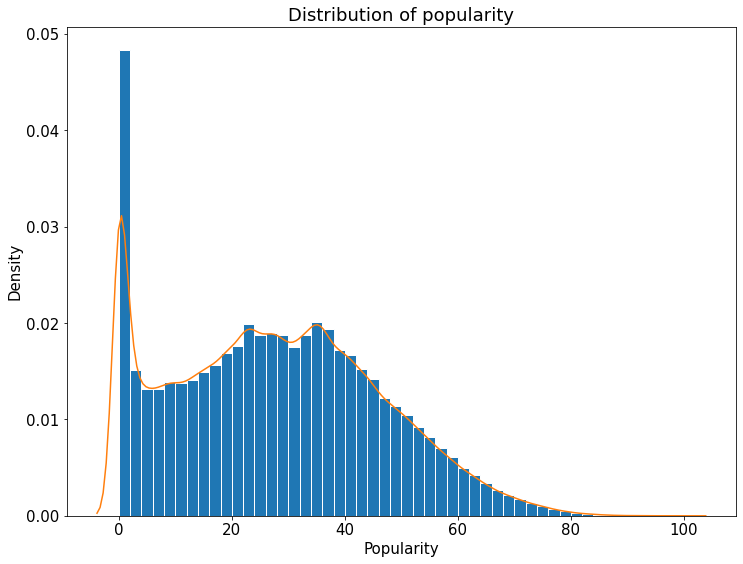

In [4]:
plt.hist(tracks.loc[:,'popularity'], ec='w', bins=50, density=True);
sns.kdeplot(tracks.loc[:,'popularity'])
plt.title("Distribution of popularity")
plt.xlabel("Popularity");

From this histogram, we can see that there are a lot of really low values (around 0), which may meddle with our modeling. Therefore, we should not use these values in our model, and will be filtering out some rows with near 0 values for popularity.

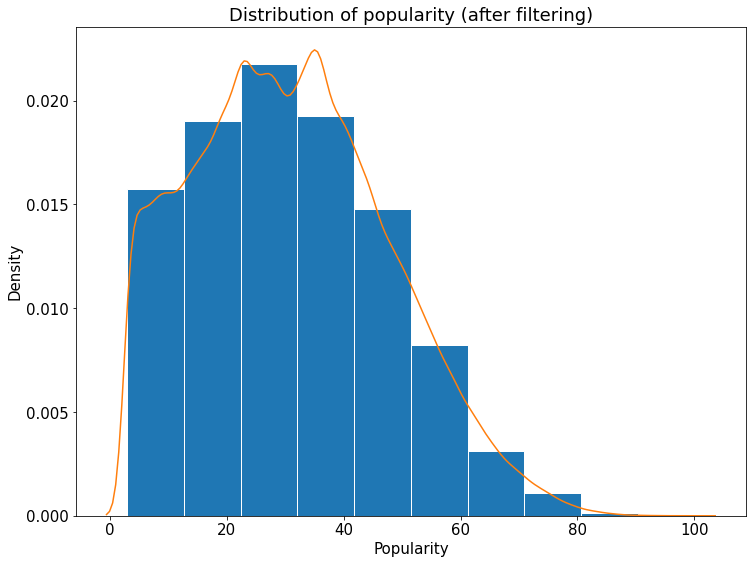

In [10]:
tracks = tracks[tracks['popularity'] > 2]
plt.hist(tracks.loc[:,'popularity'], ec='w', density=True);
sns.kdeplot(tracks.loc[:,'popularity'])
plt.title("Distribution of popularity (after filtering)")
plt.xlabel("Popularity");

Among, the features, we can first look at the `release_date` column. Intuitively, we can claim that the `release_date` would be useful for predicting `popularity`. This is because Spotify's generation of popularity for a track depends on how recently the track has been played. Let us look that this column.

In [6]:
tracks.loc[:, 'release_date']

0         1922-02-22
26              1922
149             1923
150             1923
151             1923
             ...    
586667    2020-09-26
586668    2020-10-21
586669    2020-09-02
586670    2021-03-05
586671    2015-07-01
Name: release_date, Length: 520319, dtype: object

We see that this column's entries are not numerical, or even datetime. Instead, they are strings (their ndytpe is object). To be able to use Multivariate Linear Regression, we must convert this column to a numerical column. We can do this by adding a column `num_days`, which is the number of days that day was after 1st January, 1900 (which is also the earliest date in our dataset).

In [11]:
tracks.loc[:,'datetime'] = pd.to_datetime(tracks['release_date'])
basedate = np.min(tracks['datetime'])
tracks.loc[:,'num_days'] = tracks['datetime'].apply(lambda x: 
                                                    (x - basedate).days)
tracks['num_days']

0          8087
26         8035
149        8400
150        8400
151        8400
          ...  
586667    44098
586668    44123
586669    44074
586670    44258
586671    42184
Name: num_days, Length: 520319, dtype: int64

Thus, we now have a numerical variable for days, which we can use as a potential feature in our model. From its distribution below, we can see that it is heavily left skewed. This would not work well with our linear model. We should probably transform it before using it as a feature in our model.

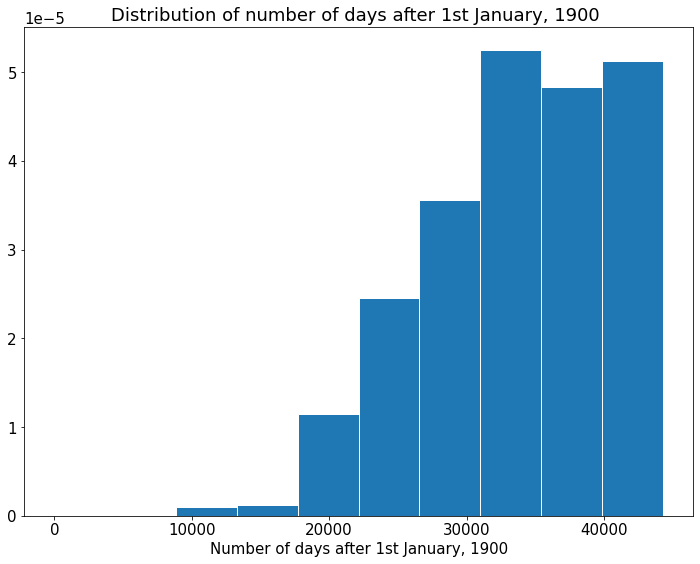

In [8]:
plt.hist(tracks.loc[:,'num_days'], ec='w', density=True);
plt.title("Distribution of number of days after 1st January, 1900 ")
plt.xlabel("Number of days after 1st January, 1900");

Let us visualize the distribution of a few numerical variables against popularity to see if they have any strong or weak correlations.

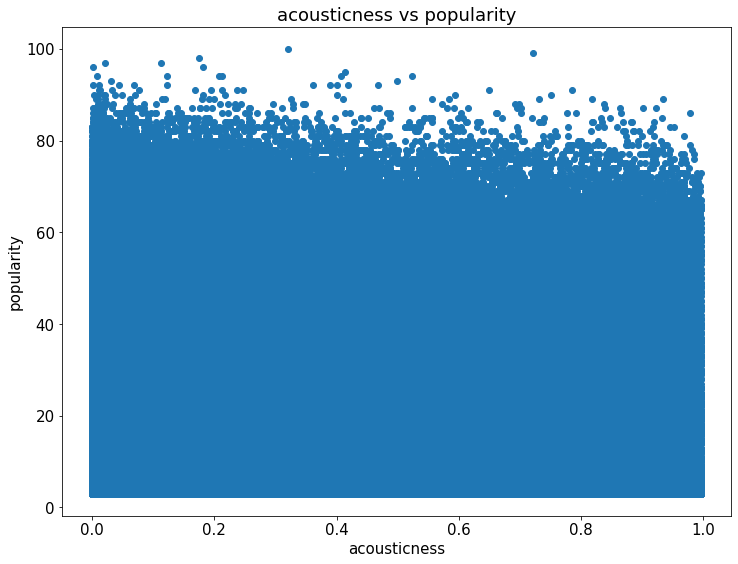

In [9]:
plt.scatter(x='acousticness', y='popularity', data=tracks);
plt.title("acousticness vs popularity")
plt.ylabel('popularity')
plt.xlabel('acousticness');

This scatter plot is too overplotted to give us any reasonable information. This is probably because we are dealing with almost 600,000 rows of data. In this case, a better plot to use would be a KDE plot.

From the plot of popularity with acousticness, it seems that there is some decent negative correlation between acousticness and popularity. However, a lot of the acousticness values around 0 meddle with the cleaner, distinct correlation. It may be helpful to filter out these values.

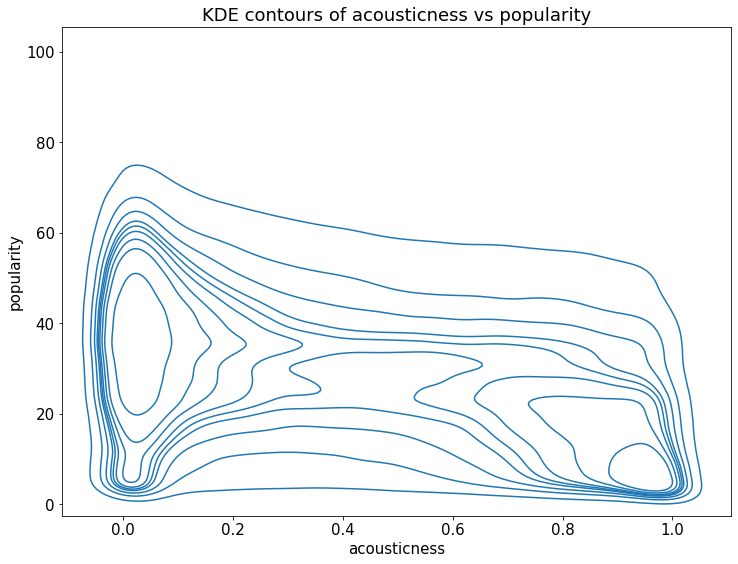

In [10]:
sns.kdeplot(x='acousticness', y='popularity', data=tracks);
plt.title("KDE contours of acousticness vs popularity")
plt.ylabel('popularity')
plt.xlabel('acousticness');

From the plot with energy and popularity, it seems that have some correlation. However, most of the energy values are distributed towards higher values. It may be helpful to transform the energy variable.

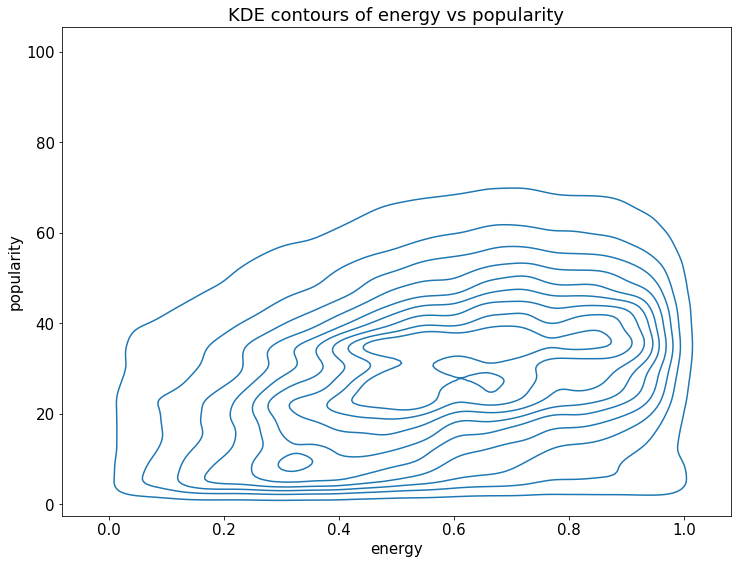

In [11]:
sns.kdeplot(x='energy', y='popularity', data=tracks);
plt.title("KDE contours of energy vs popularity")
plt.ylabel('popularity')
plt.xlabel('energy');

There doesn't seem to be any clear relation between tempo and popularity from the plot below.

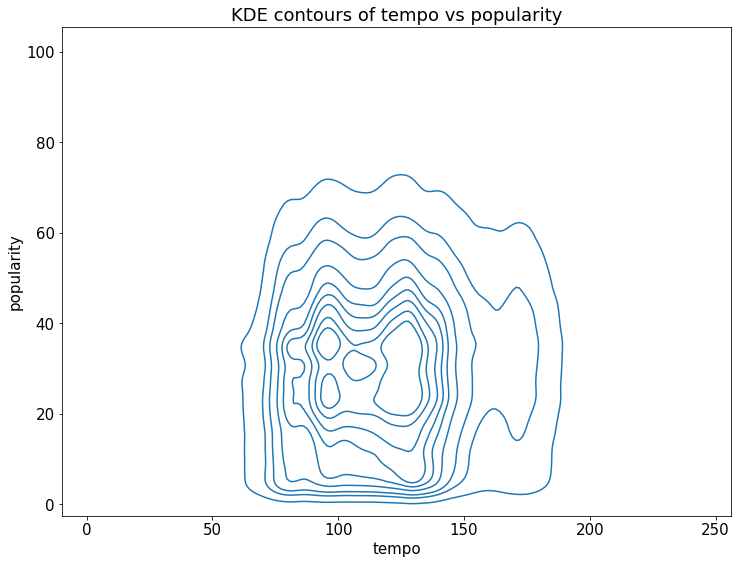

In [12]:
sns.kdeplot(x='tempo', y='popularity', data=tracks);
plt.title("KDE contours of tempo vs popularity")
plt.ylabel('popularity')
plt.xlabel('tempo');

Finally, we can analyze the categorical variables in our dataset. Variables like name and id of the song may not be too useful for our linear regression model. However, there are two interesting categorical variables, `key` and `time_signature`.

In [13]:
tracks[['key', 'time_signature']]

,key,time_signature
0,0,3
26,7,3
149,4,4
150,8,4
151,3,4
...,...,...
586667,0,4
586668,0,4
586669,7,4
586670,10,4


To use `key` and `time_signature` as features in our linear regression model, we would have to one-hot-encode these columns.

In [12]:
from sklearn.preprocessing import OneHotEncoder

def ohe_columns(data, columns=None):
    """If COLUMNS is None, fits all data."""
    oh_enc = OneHotEncoder(categories='auto')
    if columns:
        assert type(columns) == list
        data_to_fit = data[columns]
    else:
        data_to_fit = data
    oh_enc.fit(data_to_fit)
    dummies = pd.DataFrame(oh_enc.transform(data_to_fit).todense(),
                columns=oh_enc.get_feature_names(),
                index = data.index)
    for i in range(len(columns)):
        dummies = dummies.rename(columns= lambda c: 
                                 re.sub('^x'+str(i), columns[i], c))
    return data.join(dummies)

tracks_ohe = ohe_columns(tracks, columns=['key', 'time_signature'])
tracks_ohe

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,key_7,key_8,key_9,key_10,key_11,time_signature_0,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26,112adU33vo4C1eRZct2hWy,Nuits De Chine,4,180800,0,['Louis Lynel'],['28pbIiOohRRZjqpAM9iqYM'],1922,0.420,0.2880,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
149,2wAfHM7Whz67VFbdanhZlk,Nobody Knows You When You're Down and Out,41,177133,0,['Bessie Smith'],['5ESobCkc6JI4tIMxQttqeg'],1923,0.614,0.0423,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
150,3eMrYc092k7SIJfWJ7oasR,Weather Bird,38,161933,0,"['Louis Armstrong', 'Earl Hines']","['19eLuQmk9aCobbVDHc6eek', '2mY5u4CceAPrpBnse1...",1923,0.831,0.2620,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
151,2AZgaYZSwUosJD71J2N2Zo,'Tain't Nobody's Bizness If I Do,30,206600,0,['Bessie Smith'],['5ESobCkc6JI4tIMxQttqeg'],1923,0.537,0.0443,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586667,5rgu12WBIHQtvej2MdHSH0,云与海,50,258267,0,['阿YueYue'],['1QLBXKM5GCpyQQSVMNZqrZ'],2020-09-26,0.560,0.5180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
586668,0NuWgxEp51CutD2pJoF4OM,blind,72,153293,0,['ROLE MODEL'],['1dy5WNgIKQU6ezkpZs4y8z'],2020-10-21,0.765,0.6630,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
586669,27Y1N4Q4U3EfDU5Ubw8ws2,What They'll Say About Us,70,187601,0,['FINNEAS'],['37M5pPGs6V1fchFJSgCguX'],2020-09-02,0.535,0.3140,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
586670,45XJsGpFTyzbzeWK8VzR8S,A Day At A Time,58,142003,0,"['Gentle Bones', 'Clara Benin']","['4jGPdu95icCKVF31CcFKbS', '5ebPSE9YI5aLeZ1Z2g...",2021-03-05,0.696,0.6150,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Let us see the distribution of  `time_signature` values with popularity.

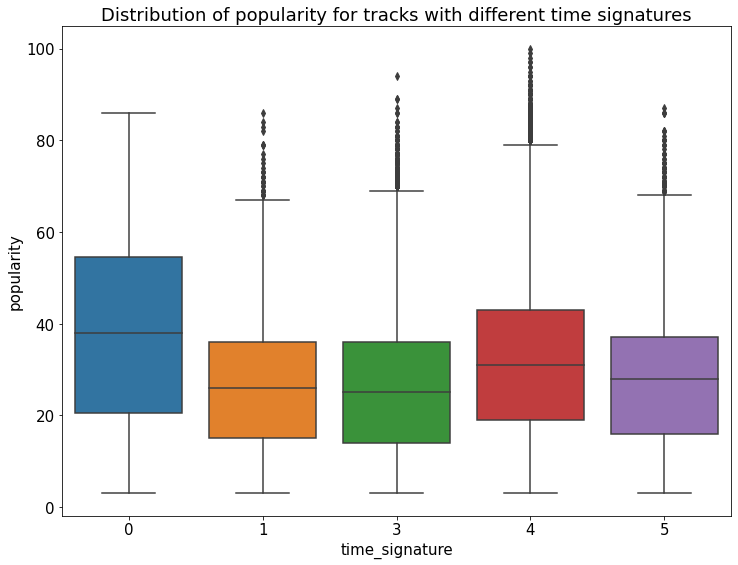

In [28]:
sns.boxplot(x='time_signature', y='popularity', data=tracks);
plt.title("Distribution of popularity for tracks with different time signatures");

Looking at our data, it seems that other time signatures are not too useful for predicting popularity. This is because most recent tracks either have a time signature of 3 or 4. And, based on domain knowledge of music, it makes sense that tracks with a 4/4 time signature are usually more popular (and common) than tracks with a 3/4 time signature.

Note that the distribtution of popularity for a time signature of 0 is really high. However, a time signature of 0 is not a common/useful thing in music. Therefore, we will not use this feature for predicting popularity.

Finally, let us look at the differences in the distribution of popularity for different keys.

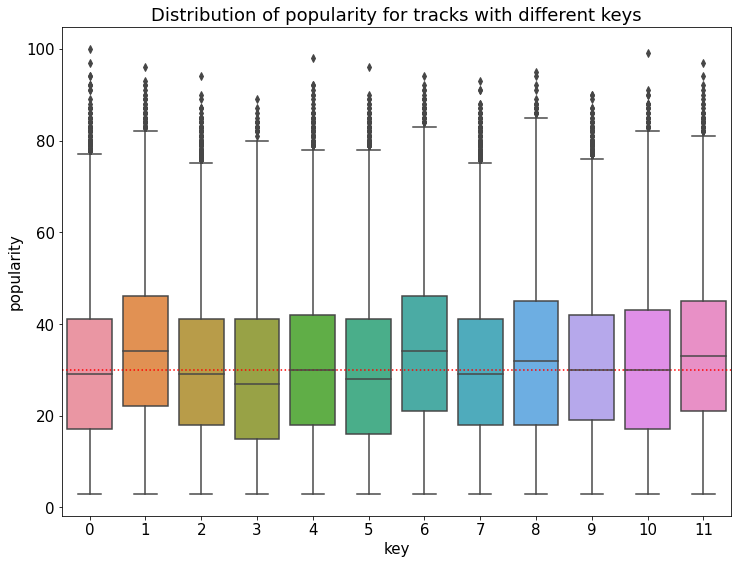

In [29]:
sns.boxplot(x='key', y='popularity', data=tracks);
plt.axhline(
        y=np.median(tracks['popularity']), 
        color='red',
        linestyle='dotted'
)
plt.title("Distribution of popularity for tracks with different keys");

The distribution of popularity for different keys doesn't seem to different - all of their medians are near the population median. By domain knowledge of music, this makes sense too - changing keys doesn't tend to affect the quality of a song too much (unless the keys are changed by a lot of distance, or nearly an octave). This also suggests that `key` may not be a useful variable to predict popularity.

# Feature processing

We can now pre-process the data, and filter and transform appropriate columns as necessary.

In [13]:
# Filter
df = tracks_ohe.copy()
df = df[(df['acousticness'] > 0.1) & (df['acousticness'] < 0.98)]
df = df[df['instrumentalness'] > 0.06]

In [14]:
# Transformations
df.loc[:,'sqrt popularity'] = np.sqrt(df.loc[:,'popularity'])
df.loc[:, 'cbrt loudness'] = np.cbrt(df.loc[:,'loudness'])
df.loc[:, 'loudness pow'] = (df['loudness'] + 60)**3
df.loc[:, 'danceability pow'] = df['danceability'] ** 1.4
df.loc[:, 'danceability exp'] = np.exp(df['danceability'])
df.loc[:, 'energy pow'] = df['energy']**1.25
df.loc[:, 'log speechiness'] = np.log(df['speechiness'])
df.loc[:, 'log speechiness sqrd'] = df['log speechiness']**2
df.loc[:, 'log duration'] = np.log(df['duration_ms'])
df.loc[:, 'log num_days'] = np.log(df['num_days'])

# Test train split

Now that we have pre-processed the data, and have added all the potential variables we would need, we can split all the data into training and testing sets. Since we have a lot of data, Even 10% of the data is good enough for the test set.

In [15]:
train, test = model_selection.train_test_split(df, test_size=0.1)
print(f'Length of train set: {train.shape[0]}')
print(f'Length of test set: {test.shape[0]}')

Length of train set: 41043
Length of test set: 4561


# Feature and model selection

Now that we have all our potential features, we need to narrow down on the features that would be useful for our prediction. We have done this using cross-validation, with the function below.

_Note: I will only show the code for how we used cross-validation to decide our features, and walk through it. However, we will not run the code, because it is very computationally heavy._

In [16]:
from sklearn.model_selection import KFold

def accuracy(actual_y, predicted_y):
    return np.mean(actual_y == predicted_y)

def compute_CV_accuracy(model, X_train, Y_train):
    kf = KFold(n_splits=4)
    validation_accs = []
    
    for train_idx, valid_idx in kf.split(X_train):
        # split the data
        split_X_train, split_X_valid = X_train.take(train_idx), X_train.take(valid_idx)
        split_Y_train, split_Y_valid = Y_train.take(train_idx), Y_train.take(valid_idx)

        # Fit the model on the training split
        model.fit(split_X_train, split_Y_train)
        split_Y_pred = model.predict(split_X_train)
        
        # Compute the accuracy on the validation split
        acc = accuracy(split_Y_valid, model.predict(split_X_valid))
        
        validation_accs.append(acc)
        
    return np.mean(validation_acc)

We now used `itertools.combinations` to try all subsets of the features we have to see which one has the lowest cross-validation accuracy, and used that subset for our model. In all, we try about $\sum_{i=1}^{n} {n\choose i}$ subsets.

In [20]:
from itertools import combinations

model = lm.LogisticRegression()
combs = []
accs = []
for i in range(1, len(features)):
    for comb in combinations(features, i):
        acc = compute_CV_accuray(model, X_train[list(comb)], y_train)
        combs.append(list(comb))
        accs.append(acc)

acc_df = pd.DataFrame({'comb': combs, 'accuracy': accs}).sort_values(
    'accuracy', ascending=False)
features = acc_df['comb'][0]

In [21]:
features = ['log num_days', 'acousticness', 'cbrt loudness', 
            'danceability', 'explicit', 'valence', 'energy pow', 
            'danceability exp', 'instrumentalness', 'time_signature_3', 
            'time_signature_4']
model = lm.LogisticRegression(max_iter=10000)
X_train, X_test = train[features], test[features]
y_train, y_test = train['is_popular'], test['is_popular']
model.fit(X_train, y_train)
print(f"Train accuracy: {model.score(X_train, y_train)}")

Train accuracy: 0.8448943790658577


# Testing our model

Our training accuracy is decent, at about 84.5%. We can now check our accuracy on our test set.

In [22]:
print(f"Test accuracy: {model.score(X_test, y_test)}")

Test accuracy: 0.846305634729226


From this, we can see that our model performs decently on unseen data too.

We can also plot the ROC curve for this model to see if it has an unwanted high false negative or false positive rate

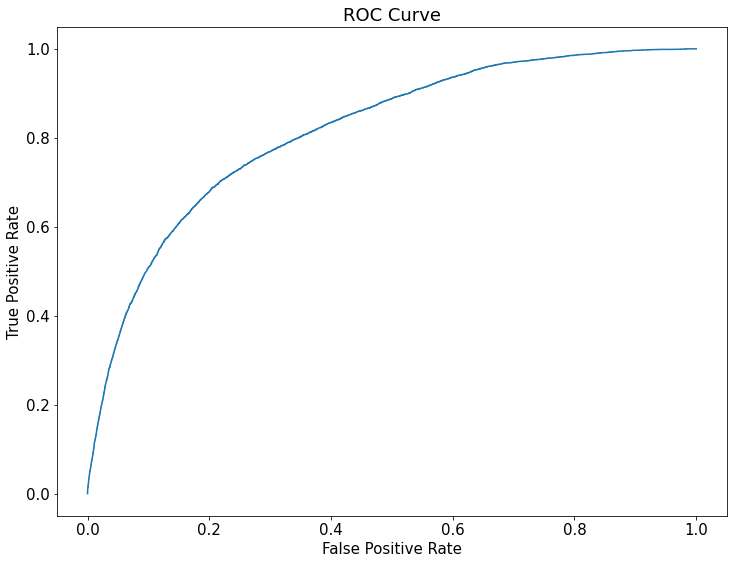

In [23]:
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(
    df['is_popular'], 
    model.predict_proba(df.drop(['is_popular', 'popularity'], axis=1)[features])[:, 1])

plt.plot(fpr, tpr);
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate");

In [24]:
print(f"Baseline accuracy: {accuracy(y_test.to_numpy(), y_train.sample(y_test.shape[0]).to_numpy())}")

Baseline accuracy: 0.7138785354089016


We can also see the baseline accuracy for this problem, from a model that (non-uniformly) randomly assigns labels to our test set. Our accuracy of about 80% is a significant improvement on this baseline accuracy of 71.4%.

# Conclusion

In our analysis, we explored predicting the popularity of a track (according to the scoring used by Spotify) based on audio features, like acousticness, danceability, or speechiness. Specifically, we want to determine whether we can determine if a track is popular or not, where we define being popular as having a popularity of greater than 40 (the population mean). 

Through my exploration of the data, I found a few patterns in the distribution of individual variables and relations among variables, which informed my feature engineering. For instance, I found that our outcome variable itself required some filtering, because a lot of the data points had near zero values, which would not work well for our prediction model. Additionally, we saw that some variables, like energy, had some significant correlation with popularity (based on their KDE plot), but it was not linear. This informed my transformation of a few variables to fit better against popularity. Finally, for categorical variables, we first one hot encoded the columns to contain a variable for each unique value of each categorical variable, which would be necessary for our model, which requires numerical data. We then found the helpful categorical variables, and the specific values of the variable that would be helpful in our prediction model, by comparing the distribution of popularity for different values of each categorical variable using boxplots. The helpful features had significantly differing distributions of popularity for the different values.

Ultimately, the features I found useful for my model were the release date, the time signature, and a few audio features. To optimize my accuracy, I performed the transformations and filtered the data according my discovery during my exploratory data analysis. Primarily, I filtered on popularity, acousticness and instrumentalness, and performed transformations on multiple columns to normalize them. Since we are predicting classes (popular or not), we used a classifier. For our prediction model, we used Logistic Regression for our classifier, since it works well for boolean outcome variables. My final model was able to predict whether a new track would be popular or not with an accuracy of about 84.5%. This is a significant improvement on our baseline accuracy of 71.4%, which is achieved by a model that randomly assigns labels to our test set.


A potential extension of this project is to use a quantitative prediction model (like Multivariate Linear Regression) to predict the exact popularity of a new track, rather than just predict whether the track would be popular or not. Another possible extension would be classify popularity into multiple ratings (like ~5 ratings), and use Random Forests to classify tracks into these ratings. Finally, this model can also be improved upon by using Natural Language Processing on lyrics of tracks and use that as features in our model.
It would be especially helpful for this model to try something other than a linear model, or to use interaction variables. This is because, it is possible that two features may individually be related positively with popularity, but negatively with each other. For example, speechiness and danceability are both positively related with popularity, but negatively with each other. Using domain knowledge, this makes sense too - speechiness is higher in rap music, which has higher popularity, but lower danceability. And dance music (like EDM) has high popularity too, but low speechiness. Therefore, using non-linear models and/or interaction variables would improve our model performance.

This project has multiple appliations in the music industry. Producers and sponsors can use this analysis to predict the popularity of a track before release, and accordingly plan their strategy. Even music platforms can use this to predict their revenue from individual tracks while deciding a price for the track. Artists themselves can tailor their music according to features positively related with popularity to improve their own tracks' popularity.